In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F


import pandas as pd
import matplotlib.pyplot as plt
# %matplotlib inline
import numpy as np

## data read


In [2]:


in_f = 10000



data_ST_list = []
for i in range(10):
    cc = np.loadtxt('disease_ST_svd_'+str(i)+'.txt')
    data_ST_list.append(cc)


data_ST_list = np.array(data_ST_list)
data_ST = np.resize(data_ST_list,(5000,10000))

data_ST_ = []
for i in range(data_ST.shape[0]):
    data_ST_.append(data_ST[i][0:in_f])

data_ST_ = np.array(data_ST_)


del data_ST, data_ST_list





data_SB_list = []
for i in range(10):
    cc = np.loadtxt('disease_SB_svd_'+str(i)+'.txt')
    data_SB_list.append(cc)


data_SB_list = np.array(data_SB_list)
data_SB = np.resize(data_SB_list,(5000,10000))

data_SB_ = []
for i in range(data_SB.shape[0]):
    data_SB_.append(data_SB[i][0:in_f])

data_SB_ = np.array(data_SB)


del data_SB, data_SB_list




data_SR_list = []
for i in range(10):
    cc = np.loadtxt('disease_SR_svd_'+str(i)+'.txt')
    data_SR_list.append(cc)


data_SR_list = np.array(data_SR_list)
data_SR = np.resize(data_SR_list,(5000,10000))

data_SR_ = []
for i in range(data_SR.shape[0]):
    data_SR_.append(data_SR[i][0:in_f])

data_SR_ = np.array(data_SR_)


del data_SR, data_SR_list





In [3]:
data_all= np.concatenate((data_ST_,data_SB_,data_SR_),axis=0)

In [4]:
len(data_all[0])


10000

In [5]:
# from sklearn.decomposition import PCA

# pca = PCA(n_components=250)  # reduce to 100 features
# data_all = pca.fit_transform(data_all)

###  old data merge

In [6]:
# data_ST_train = []
# data_SR_train = []
# data_SB_train = []

# for i in range(2500):
#     data_SB_train.append(data_SB_[i])
#     data_SR_train.append(data_SR_[i])
#     data_ST_train.append(data_ST_[i])



# data_ST_test = []
# data_SR_test = []
# data_SB_test = []

# for i in range(3000,4000):
#     data_SB_test.append(data_SB_[i])
#     data_SR_test.append(data_SR_[i])
#     data_ST_test.append(data_ST_[i])


# data_train = data_SB_train + data_SR_train + data_ST_train
# data_test = data_SB_test + data_SR_test + data_ST_test


# del data_SB_train, data_SR_train, data_ST_train
# del data_SB_test, data_SR_test, data_ST_test





In [7]:
# label_train = []
# for i in range(2500):
#     label_train.append(0)

# for i in range(2500):
#     label_train.append(1)

# for i in range(2500):
#     label_train.append(2)

# label_train = np.array(label_train)

# label_test = []
# for i in range(1000):
#     label_test.append(0)

# for i in range(1000):
#     label_test.append(1)

# for i in range(1000):
#     label_test.append(2)

# label_test = np.array(label_test)


### random merge

In [8]:
# list of 5000 0s then 5000 1s then 5000 2s
label = []
for j in range(3):
    for i in range(5000):
        label.append(j)


In [9]:
len(label)

15000

In [10]:
from sklearn.model_selection import train_test_split
data_train, data_test, label_train, label_test = train_test_split(data_all, label, test_size=0.2, random_state=42)

In [11]:
data_train = torch.FloatTensor(data_train)
label_train = torch.LongTensor(label_train)

data_test = torch.FloatTensor(data_test)
label_test = torch.LongTensor(label_test)

In [12]:
class Model(nn.Module):
  def __init__(self, in_features= 10000 , h1= 2000  , h2= 500,
                h3 = 200 , h4 = 50, h5 = 10,
                    out_features=3):
    super().__init__()
    self.fc1 = nn.Linear(in_features, h1)
    self.fc2 = nn.Linear(h1, h2)
    self.fc3 = nn.Linear(h2, h3)
    self.fc4 = nn.Linear(h3, h4)
    self.fc5 = nn.Linear(h4, h5)


    self.out = nn.Linear(h5, out_features)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.relu(self.fc4(x))
    x = F.relu(self.fc5(x))


    x = self.out(x)

    return x


torch.manual_seed(42)
model = Model()

def restart():
    torch.manual_seed(42)
    model = Model()
    return model


In [13]:
# accuracy
def accuracy(y_pred, y_test):
  correct = 0
  for i in range(len(y_pred)):
    if y_pred[i] == y_test[i]:
      correct += 1
  return correct / len(y_pred)

In [14]:
model=restart()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01
                             )

epochs = 1000
# epochs = 100
losses = []
validation_losses = []
for i in range(epochs):
  
  y_pred = model.forward(data_train) 

  loss = criterion(y_pred, label_train) 

  # Evaluate Model on Test Data Set (validate model on test set)
  with torch.no_grad():  # Basically turn off back propogation
    y_eval = model.forward(data_test) # X_test are features from our test set, y_eval will be predictions
    validation_loss = criterion(y_eval, label_test) # Find the loss or error
    validation_losses.append(validation_loss.detach().numpy().item())



  losses.append(loss.detach().numpy().item())

  if i % 100 == 0:
    print(f'Epoch: {i} and train loss: {loss} | validation loss : {validation_loss}')
    acc= accuracy(y_eval.argmax(1), label_test)
    acc_train = accuracy(y_pred.argmax(1), label_train)
    print(f'Epoch: {i} Accuracy Train: {acc_train} | Accuracy Test: {acc}')

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()





/home/karansingh/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/karansingh/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:749: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() if nvml_count < 0 else nvml_count


Epoch: 0 and train loss: 1.122922420501709 | validation loss : 1.1173334121704102
Epoch: 0 Accuracy Train: 0.33025 | Accuracy Test: 0.3456666666666667
Epoch: 100 and train loss: 0.13138790428638458 | validation loss : 1.0542073249816895
Epoch: 100 Accuracy Train: 0.96525 | Accuracy Test: 0.8313333333333334
Epoch: 200 and train loss: 0.47628170251846313 | validation loss : 0.8657419681549072
Epoch: 200 Accuracy Train: 0.8204166666666667 | Accuracy Test: 0.7373333333333333
Epoch: 300 and train loss: 0.008209360763430595 | validation loss : 1.8656132221221924
Epoch: 300 Accuracy Train: 0.9975833333333334 | Accuracy Test: 0.831
Epoch: 400 and train loss: 0.0029321787878870964 | validation loss : 3.427396774291992
Epoch: 400 Accuracy Train: 0.9985833333333334 | Accuracy Test: 0.8263333333333334
Epoch: 500 and train loss: 0.0024740048684179783 | validation loss : 3.985745668411255
Epoch: 500 Accuracy Train: 0.9988333333333334 | Accuracy Test: 0.8266666666666667
Epoch: 600 and train loss: 5.0

In [15]:
losses = np.array(losses)
np.savetxt('loss_model_.txt', losses)

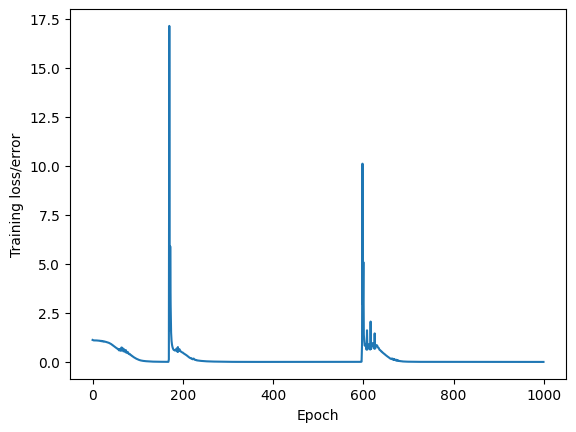

In [16]:
plt.plot(range(len(losses)), losses)
plt.ylabel("Training loss/error")
plt.xlabel('Epoch')
plt.savefig('training_loss.png')

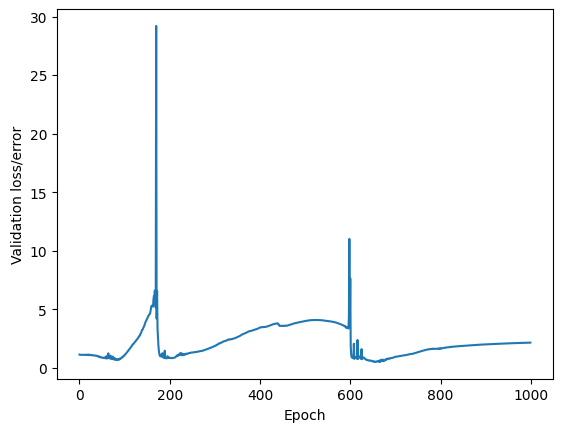

In [17]:
plt.plot(range(len(validation_losses)), validation_losses)
plt.ylabel("Validation loss/error")
plt.xlabel('Epoch')



plt.savefig('validation_loss.png')


